# Customer Churn Predictions 
(End-to-end customer churn prediction project) 
### Using Telco Customer Churn dataset 

In [1]:
# Check to make sure dpendencies are installed

In [3]:
# Importing libraries 
import os 
import warnings 
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path 


In [4]:
# Setting random_state for reproducibility 
random_state = 42 
np.random.seed(random_state) 


In [17]:
# Defining folder paths 
# Current directory --> Notebooks/ 
#data_path = "../Data/telco_churn_data.csv" 
#visuals_path = "../Visuals"
#model_path = "../Models"   

data_path = Path('../Data/telco_churn_data.csv').resolve() 
base_data_path = Path('../Data').resolve() 
visuals_path = Path('../Visuals').resolve()  
models_path = Path('../Models').resolve() 

visuals_path.mkdir(parents=True, exist_ok=True) 
models_path.mkdir(parents=True, exist_ok=True) 

print("Data Path --> ", data_path) 
print("Base Data Path -- ", base_data_path) 
print("Visuals Path --> ", visuals_path) 
print("Models Path --> ", models_path) 

# Function to save data file(s) to Data/ folder 
def save_data(data: pd.DataFrame, file_name: str): 
    os.makedirs(base_data_path, exist_ok=True) 
    file_path = os.path.join(base_data_path, f"{file_name}.csv") 
    data.to_csv(file_path, index=False) 
    print(f"Saved -> {file_path}") 


Data Path -->  /workspaces/Customer-Churn-Prediction/Data/telco_churn_data.csv
Base Data Path --  /workspaces/Customer-Churn-Prediction/Data
Visuals Path -->  /workspaces/Customer-Churn-Prediction/Visuals
Models Path -->  /workspaces/Customer-Churn-Prediction/Models


In [18]:
# Plotting settings 
sns.set_style('whitegrid') 
plt.rcParams['figure.figsize'] = (10,6) 


In [19]:
# Loading data 

# file path check 
if not data_path.exists(): 
    raise FileNotFoundError(f"Expected data at {data_path}.") 

telco_data = pd.read_csv(data_path) 
telco_data.head() 
print("\nData Info: ")
print(telco_data.info())  




Data Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-nu

In [20]:
data = telco_data.copy() 

# Data checks 
print("\nMissing values: ") 
print(data.isna().sum()) 

# Checking if there are duplicate customerID values 
print("\nAll unique customerID --> ", data['customerID'].nunique() == len(data)) 

# Converting TotalCharges to numeric 
if data['TotalCharges'].dtype == 'object': 
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') 
    print("\nTotalCharges NA count (After numeric conversion): ", data['TotalCharges'].isna().sum())

# Checking if any rows have tenure == 0 & TotalCharges == NaN 
# Possible for new customers 
new_cust = (data['tenure'] == 0) & (data['TotalCharges'].isna()) 
print("\nRows with tenure == 0 & TotalCharges == NaN : ", new_cust.sum()) 




Missing values: 
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

All unique customerID -->  True

TotalCharges NA count (After numeric conversion):  11

Rows with tenure == 0 & TotalCharges == NaN :  11


In [21]:
# Changing TotalCharges to 0 if tenure==0 (Assumed it is a new customer) 
# If any TotalCharges==NaN remain these will be handled later 
data.loc[(data['tenure']==0) & (data['TotalCharges'].isna()), 'TotalCharges'] = 0.0 
print("Remaining NaN TotalCharges values after fix: ", data['TotalCharges'].isna().sum()) 


Remaining NaN TotalCharges values after fix:  0


In [27]:
# Encoding the SeniorCitizen column to match the other columns (converting 0/1 to labels) 
data['SeniorCitizen'] = data['SeniorCitizen'].map({0:'No', 1:'Yes'}) 
print(data['SeniorCitizen'].head())


0    No
1    No
2    No
3    No
4    No
Name: SeniorCitizen, dtype: object


In [28]:
# Saving cleaned data to Data/ folder 
save_data(data, "cleaned_raw_data") 


Saved -> /workspaces/Customer-Churn-Prediction/Data/cleaned_raw_data.csv


### Exploratory Data Analysis (EDA) 
Looking at group churn rates, population comparisons, visualziations, and interpretations. 

In [23]:
# Finding baseline churn rate (Total churn rate) 
print("Baseline churn:") 
print(data['Churn'].value_counts(normalize=True)) 


Baseline churn:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


**Baseline Churn Rate: 26.54%**

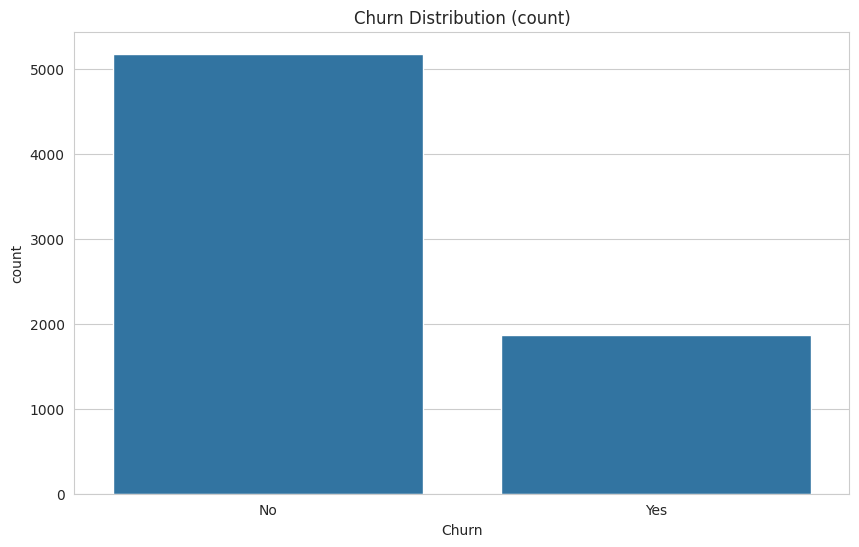

In [24]:
# Churn distribution 
ax = sns.countplot(x='Churn', data=data) 
ax.set_title("Churn Distribution (count)") 
plt.show() 


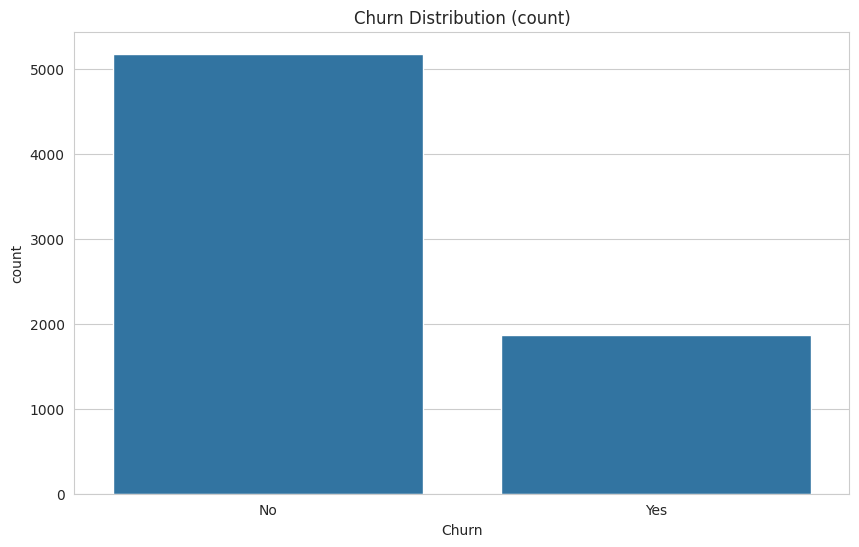

In [25]:
# Savings churn distribution figure to Visuals/ folder 
ax = sns.countplot(x='Churn', data=data) 
ax.set_title("Churn Distribution (count)") 
plt.savefig(visuals_path / 'churn_distribution.png', dpi=150, bbox_inches='tight') 


In [26]:
test_crosstab = pd.crosstab(data['Partner'], data['Churn'], normalize='index') 
test_crosstab = test_crosstab.rename(columns={'No': 'churn_no_pct', 'Yes': 'churn_yes_pct'}) 
test_crosstab

Churn,churn_no_pct,churn_yes_pct
Partner,,
No,0.670420,0.329580
Yes,0.803351,0.196649


In [ ]:
# Creating helper function to calculate cross-tabulations and group churn rates 
def group_churn(data, group_column, target='Churn'): 
    cross_tab = pd.crosstab(data[group_column], data[target], normalize='index') 
    cross_tab = cross_tab.rename(columns={'No': 'churn_no_pct', 'Yes': 'churn_yes_pct'}) 
    # Population comparison 
    population_share = data[group_column].value_counts(normalize=True).rename('population_share') 
    result = cross_tab.join(population_share) 
    result['group_churn'] = result['churn_yes_pct'] 
    result['population_churn_share'] = result['population_share'] * result['churn_yes_pct'] 
    return result 



In [ ]:
# 



In [ ]:
# Loading data 
data_path = "../Data/telco_churn_data.csv"
telco_data = pd.read_csv(data_path)  
print(telco_data.info()) 
print("\n", telco_data.head())


# Saving cleaned data to data folder 
def save_data(data: pd.DataFrame, file_name: str): 
    os.makedirs(save_path, exist_ok=True) 
    file_path = os.path.join(save_path, f"{file_name}.csv") 
    data.to_csv(file_path, index=False) 
    print(f"Saved -> {file_path}") 

#save_path = "../Data/" 
#save_data(cleaned_data, "cleaned_churn_data") 

In [ ]:
# Machine Learning Libraries 
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV  
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    roc_curve, 
    precision_recall_curve, 
    classification_report, 
    confusion_matrix
)
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline 

import joblib 

# Heavy Libraries 
try: 
    import xgboost as xgb 
except Exception: 
    xgb = None 

try: 
    import shap 
except Exception: 
    shap = None 
